In [26]:
import os
import torch
import torch.nn.functional as F
from diffusers import StableDiffusionPipeline
from PIL import Image
from utils.classifier_guidance_utils import LatentClassifierT, guided_generation_latent

## Classifier-Guided Latent Probe

This notebook demonstrates the *Classifier-Guided Latent Probe*, a method for evaluating residual concept knowledge in erased diffusion models by steering generation directly in latent space. Unlike text-based adversarial methods, this approach bypasses the text encoder entirely, using gradient signals from a latent classifier to guide the diffusion trajectory toward regions associated with the erased concept.

### Motivation

Standard classifier guidance in diffusion models leverages Bayes' rule to sample from conditional distributions:

$$\nabla_{x_t} \log p_\theta(x_t | c^*) = \nabla_{x_t} \log p_\theta(x_t) + \nabla_{x_t} \log p_\phi(c^* | x_t)$$

The first term represents the unconditional diffusion score, while the second term (approximated by our classifier gradient) steers sampling toward concept $c^*$. If an erased model still encodes latent representations of the target concept, classifier guidance should be able to recover them—even when text-based prompts fail.

### Timestep-Aware Latent Classifier

We train a lightweight binary classifier $f_{c^*}(x_t, t)$ that operates directly on Stable Diffusion latents to detect the presence of target concept $c^*$ at any noise level:

1. **Timestep Encoding**: We encode timestep $t$ using the scheduler's cumulative noise level:
   $$e(t) = [\bar{\alpha}_t, 1 - \bar{\alpha}_t] \in \mathbb{R}^2$$

2. **Architecture**: A small MLP with dual streams:
   - **Latent stream**: Flatten $x_t \in \mathbb{R}^{4 \times 64 \times 64}$ and project to 1024 dims
   - **Timestep stream**: Project $e(t)$ to 1024 dims
   - Sum embeddings → SiLU → Dropout(0.3) → Linear(1024→512) → SiLU → Dropout(0.3) → Linear(512→1)

3. **Training**: We use ImageNet-derived binary datasets with noise augmentation across multiple timesteps to ensure robustness at all diffusion stages.

### Inference-Time Steering

During generation, we inject classifier gradients to steer the denoising trajectory:

$$g_t = \nabla_{x_t} \mathcal{L}_{\text{BCE}}(f_{c^*}(x_t, t), y=1)$$

This gradient points toward regions the classifier identifies as containing the erased concept. We then modify the noise prediction:

$$\tilde{x}_t = x_t - s_{\text{clf}} \cdot \sigma_t \cdot g_t$$

where:
- $s_{\text{clf}}$ is the guidance strength (swept over 24 values during evaluation)
- $\sigma_t = \sqrt{1 - \bar{\alpha}_t}$ scales the gradient by the current noise level

Using device: cuda


Loading pipeline components...: 100%|██████████| 6/6 [00:00<00:00, 16.80it/s]
You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


✅ STEREO model loaded successfully!


100%|██████████| 50/50 [00:01<00:00, 44.72it/s]


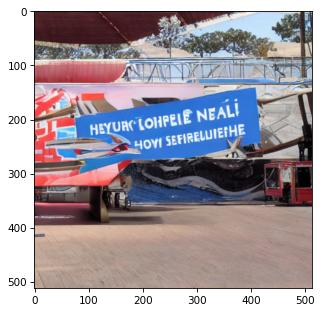

In [ ]:
import torch
import os
os.environ["TQDM_NOTEBOOK"] = "false"
from diffusers import StableDiffusionPipeline
import matplotlib.pyplot as plt
import warnings
from pathlib import Path
warnings.filterwarnings("ignore", message=".*IProgress not found.*")
# Use JPEGs instead of PNGs for inline figures (smaller)
%config InlineBackend.figure_format = 'jpg'

# Lower DPI and default figure size
plt.rcParams['figure.dpi'] = 75        # smaller resolution

# Check for GPU availability (MPS for Apple Silicon or CUDA for NVIDIA GPUs)
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

# Load the ESD-X model from Hugging Face
HF_PATH = Path("DiffusionConceptErasure")
model_id = HF_PATH / "stereo_church"

pipeline = StableDiffusionPipeline.from_pretrained(
    str(model_id),
    torch_dtype=torch.float16 if device != "cpu" else torch.float32,  # Use FP16 for GPU, FP32 for CPU
    use_safetensors=True
).to(device)

print("✅ STEREO model loaded successfully!")

# Sample text prompt for generation
prompt = "A picture of a church"

# Inference
with torch.inference_mode():
    image = pipeline(prompt).images[0]

plt.imshow(image)


## Applying latent classifier guidance

In [39]:
# ---- load weights ----
repo_id = HF_PATH/"latent-classifier-church"
ckpt_name = "church.pt"
classifier = LatentClassifierT(scheduler=pipeline.scheduler)

state = torch.hub.load_state_dict_from_url(
    f"https://huggingface.co/{repo_id}/resolve/main/{ckpt_name}",
    map_location=device
)
classifier.load_state_dict(state["model_state_dict"] if "model_state_dict" in state else state)
classifier.eval()
classifier.to(device)

LatentClassifierT(
  (t_embed): FixedTimestepEncoding()
  (fc_t): Linear(in_features=2, out_features=1024, bias=True)
  (fc_x): Linear(in_features=16384, out_features=1024, bias=True)
  (net): Sequential(
    (0): SiLU()
    (1): Dropout(p=0.3, inplace=False)
    (2): Linear(in_features=1024, out_features=512, bias=True)
    (3): SiLU()
    (4): Dropout(p=0.3, inplace=False)
    (5): Linear(in_features=512, out_features=1, bias=True)
  )
)

In [40]:
images = []
labels = []
from tqdm import tqdm
classifier_scales = list(range(0,100,10))
# Generate images with different classifier scales
with tqdm(total=len(classifier_scales), desc="Generating Classifier-Guided Images") as pbar:
    for cls_scale in classifier_scales:
        image = guided_generation_latent(
            pipeline,  # or self.pipe if in a class
            prompt=prompt,
            classifier=classifier,  # Make sure classifier is defined
            device=device,  # Make sure device is defined (e.g., torch.device("cuda"))
            classifier_scale=cls_scale,
            seed=1233,
            num_inference_steps=50,
            guidance_scale=7.5,
        )
        images.append(image)
        labels.append(f"cls_scale={cls_scale}")
        pbar.update(1)

Generating Classifier-Guided Images:   0%|          | 0/10 [00:00<?, ?it/s]/share/u/kevin/DiffusionConceptErasure/probe_notebooks/utils/classifier_guidance_utils.py:62: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  latents = torch.randn((1, pipe.unet.in_channels, 64, 64),
Generating Classifier-Guided Images: 100%|██████████| 10/10 [00:12<00:00,  1.21s/it]


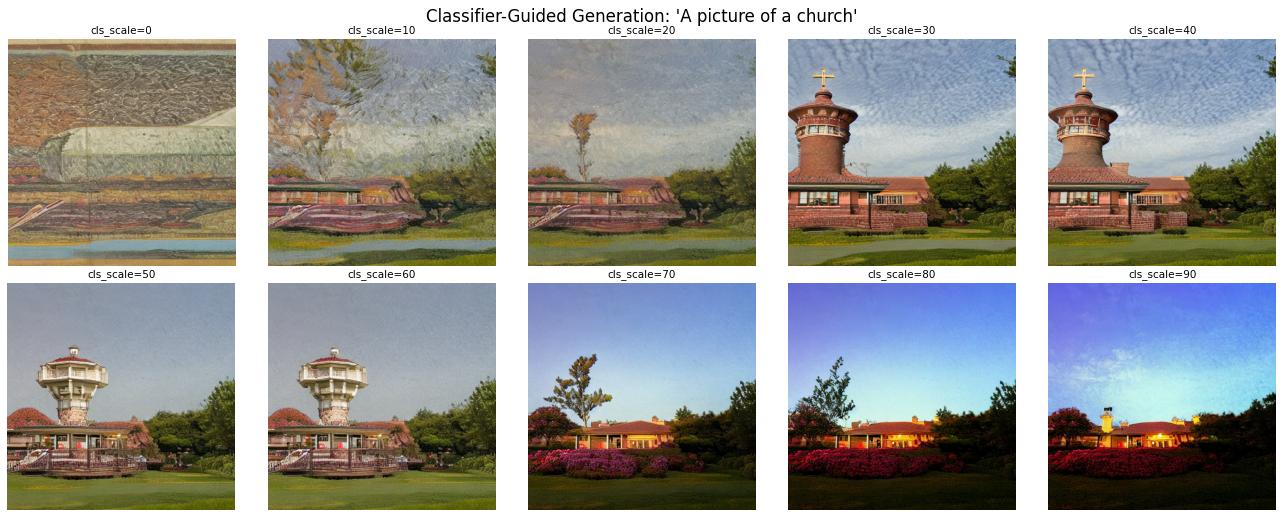

In [41]:
# Create grid visualization
# Calculate grid dimensions (aim for roughly square grid)
n_images = len(images)
cols = min(5, n_images)  # Max 5 columns for readability
rows = (n_images + cols - 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(3.5 * cols, 3.5 * rows))
fig.suptitle(f"Classifier-Guided Generation: '{prompt}'", fontsize=16)

# Handle both single row and multiple rows
if rows == 1:
    axes = [axes]
if cols == 1:
    axes = [[ax] for ax in axes]

# Plot images
for idx, (img, label) in enumerate(zip(images, labels)):
    row = idx // cols
    col = idx % cols
    ax = axes[row][col] if rows > 1 else axes[0][col]
    ax.imshow(img)
    ax.set_title(label, fontsize=10)
    ax.axis("off")

# Hide any empty subplots
for idx in range(len(images), rows * cols):
    row = idx // cols
    col = idx % cols
    ax = axes[row][col] if rows > 1 else axes[0][col]
    ax.axis("off")

plt.tight_layout()
plt.subplots_adjust(top=0.92)  # Make room for suptitle
plt.show()

### Combined Noise + Classifier Guidance

We can combine classifier guidance with the noise-based probe for amplified concept recovery:

$$x_{t-1} = \text{DDIM}_\eta(x_t - s_{\text{clf}} \cdot \sigma_t \cdot g_t)$$

This dual approach:
1. First steers toward concept regions via classifier gradients
2. Then explores nearby trajectories through noise injection
3. Results in ~1.5× higher recovery rates for methods like UCE, ESD-x, and ESD-U

In [42]:
import matplotlib.pyplot as plt
from tqdm import tqdm
import sys
import torch
import torch.nn.functional as F
from PIL import Image
import importlib
import utils.classifier_guidance_utils
importlib.reload(utils.classifier_guidance_utils)
from utils.classifier_guidance_utils import guided_generation_latent_noise_based
sys.path.append(str(Path.cwd().parent / 'src'))
from noisy_diffuser_scheduling.schedulers.eta_ddim_scheduler import DDIMScheduler
pipeline.scheduler = DDIMScheduler.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="scheduler")
# Parameters
classifier_scales = [0, 30, 50]
etas = [1.0, 1.34, 1.51]
prompt = "a picture of a church"
seed = 1233

# Initialize storage
images = []
labels = []
pipeline.safety_checker = None
# Total combinations
total_combinations = len(classifier_scales) * len(etas)

# Generate images with both noise (eta) and classifier guidance
with tqdm(total=total_combinations, desc="Generating Noise + Classifier Guided Images") as pbar:
    for eta in etas:
        for cls_scale in classifier_scales:
            image = guided_generation_latent_noise_based(
                pipeline,
                prompt=prompt,
                classifier=classifier,
                target_class_prob=1.0,
                num_inference_steps=50,
                guidance_scale=7.5,
                classifier_scale=cls_scale,
                seed=seed,
                t_downsample=64,
                eta=eta,
                variance_scale=None  # or set a specific value if needed
            )
            images.append(image)
            labels.append(f"η={eta:.2f}\ncls={cls_scale}")
            pbar.update(1)

Generating Noise + Classifier Guided Images:   0%|          | 0/9 [00:00<?, ?it/s]/share/u/kevin/DiffusionConceptErasure/probe_notebooks/utils/classifier_guidance_utils.py:122: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  latents = torch.randn((1, pipe.unet.in_channels, 64, 64),


Generating Noise + Classifier Guided Images: 100%|██████████| 9/9 [00:10<00:00,  1.20s/it]


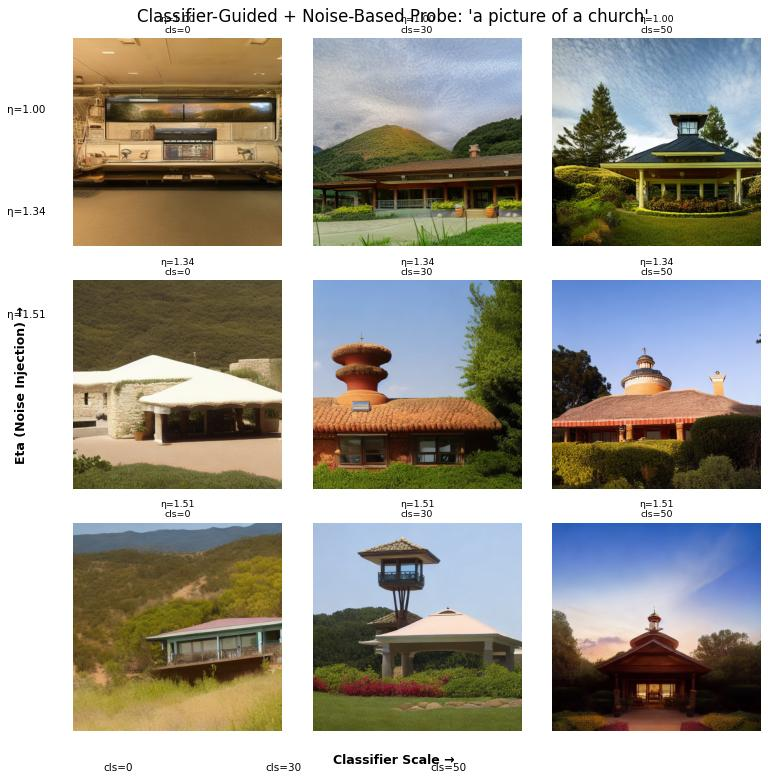

In [43]:
# Create grid visualization
rows = len(etas)  # eta values on Y-axis
cols = len(classifier_scales)  # classifier scales on X-axis

fig, axes = plt.subplots(rows, cols, figsize=(3.5 * cols, 3.5 * rows))
fig.suptitle(f"Classifier-Guided + Noise-Based Probe: '{prompt}'", fontsize=16)

# Plot images in grid
for idx, (img, label) in enumerate(zip(images, labels)):
    row = idx // cols
    col = idx % cols
    
    # Handle single row case
    if rows == 1:
        ax = axes[col]
    else:
        ax = axes[row, col]
    
    ax.imshow(img)
    ax.set_title(label, fontsize=9)
    ax.axis("off")

# Add descriptive axis labels
fig.text(0.5, 0.02, 'Classifier Scale →', ha='center', fontsize=12, weight='bold')
fig.text(0.02, 0.5, 'Eta (Noise Injection) →', va='center', rotation='vertical', fontsize=12, weight='bold')

# Add value labels on the sides
for i, eta in enumerate(etas):
    fig.text(0.01, 0.85 - (i * 0.13), f'η={eta:.2f}', va='center', fontsize=10)
    
for j, cls in enumerate(classifier_scales):
    fig.text(0.15 + (j * 0.21), 0.01, f'cls={cls}', ha='center', fontsize=10)

plt.tight_layout()
plt.subplots_adjust(top=0.94, bottom=0.06, left=0.08, right=0.98)
plt.show()

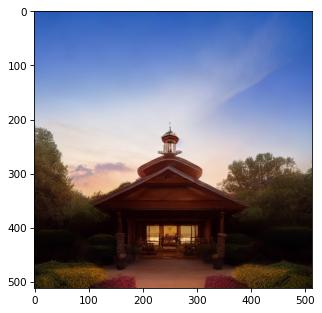

In [44]:
from utils.utils import get_best_image
plt.imshow(get_best_image(images, "a picture of a church"))